# Move class into separate species folder

In [7]:
import pandas as pd
import os
import shutil

In [9]:
species_directory = '/users/PAS2186/balasubramaniam29/new/Split_dataset'
det_directory = '/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset'
csv_file_path = 'all_species_info.csv'
df = pd.read_csv(csv_file_path)

for split in os.listdir(species_directory):
    split_path = os.path.join(species_directory, split)
    
    if os.path.isdir(split_path):
        for order in os.listdir(split_path):
            if order in ["Amphibia", "Aves", "Serpentes", "Mammalia"]:
                order_path = os.path.join(split_path, order)

                if os.path.isdir(order_path):
                    for files in os.listdir(order_path):
                        files_path = os.path.join(order_path, files)
                        species_info = df[df['Image Name'] == files]

                        if not species_info.empty:
                            species_name = species_info['Species Name'].values[0]
                            output = os.path.join(det_directory, order, split, species_name)
                            class_path = os.path.join(order_path, species_name)
                            os.makedirs(output, exist_ok=True)

                            destination_image = os.path.join(output, files)
                            shutil.copy(files_path, destination_image)

# Remove some images from Easter Garter Snake

In [22]:
import os
import random
import shutil

def create_subset(source_dir, dest_dir, num_images):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # List all files in the source directory
    all_images = os.listdir(source_dir)

    # Randomly select num_images from the list
    selected_images = random.sample(all_images, num_images)

    # Move selected images to the destination directory
    for image in selected_images:
        source_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        shutil.copy(source_path, dest_path)

if __name__ == "__main__":
    # Specify the source directory, destination directory, and the number of images
    source_directory = "/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Serpentes/val/Eastern"
    destination_directory = "/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Serpentes/val/Eastern Gartersnake"
    num_images_to_select = 100

    # Call the function to create the subset
    create_subset(source_directory, destination_directory, num_images_to_select)


## Split the input dataset into subfolders 

In [30]:
import splitfolders

In [31]:
#Species level
input_folder = '/users/PAS2186/balasubramaniam29/Latest species classifier backup/Sorted_by_species/Serpentes'
splitfolders.ratio(input_folder, 
                           output="/users/PAS2186/balasubramaniam29/new/Individual training/splitimages/Serpentes", 
                           seed=42, 
                           ratio=(.7, .2, .1),
                           group_prefix=None,
                           move=False
                          )

Copying files: 36116 files [14:56, 40.29 files/s]


## Import necessary packages

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow.keras
from PIL import Image, ImageOps
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os


2024-03-27 09:12:58.486089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-27 09:12:58.668821: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-27 09:12:58.674355: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-27 09:12:58.674377: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
image_size = 224
batch_size = 64

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create image generator

In [48]:
base_dir = '/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Serpentes/'
train_dir = base_dir+ 'train/'
val_dir = base_dir + 'val/'
testing_dir = base_dir + '/test/'
input_shape = (image_size, image_size, 3)

In [49]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02,
                              width_shift_range=0.02,
                              rotation_range=-0.1,
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.3,
                              brightness_range=(0.5, 1.5))

In [50]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 4157 images belonging to 14 classes.


In [51]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 516 images belonging to 14 classes.


In [52]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 793 images belonging to 14 classes.


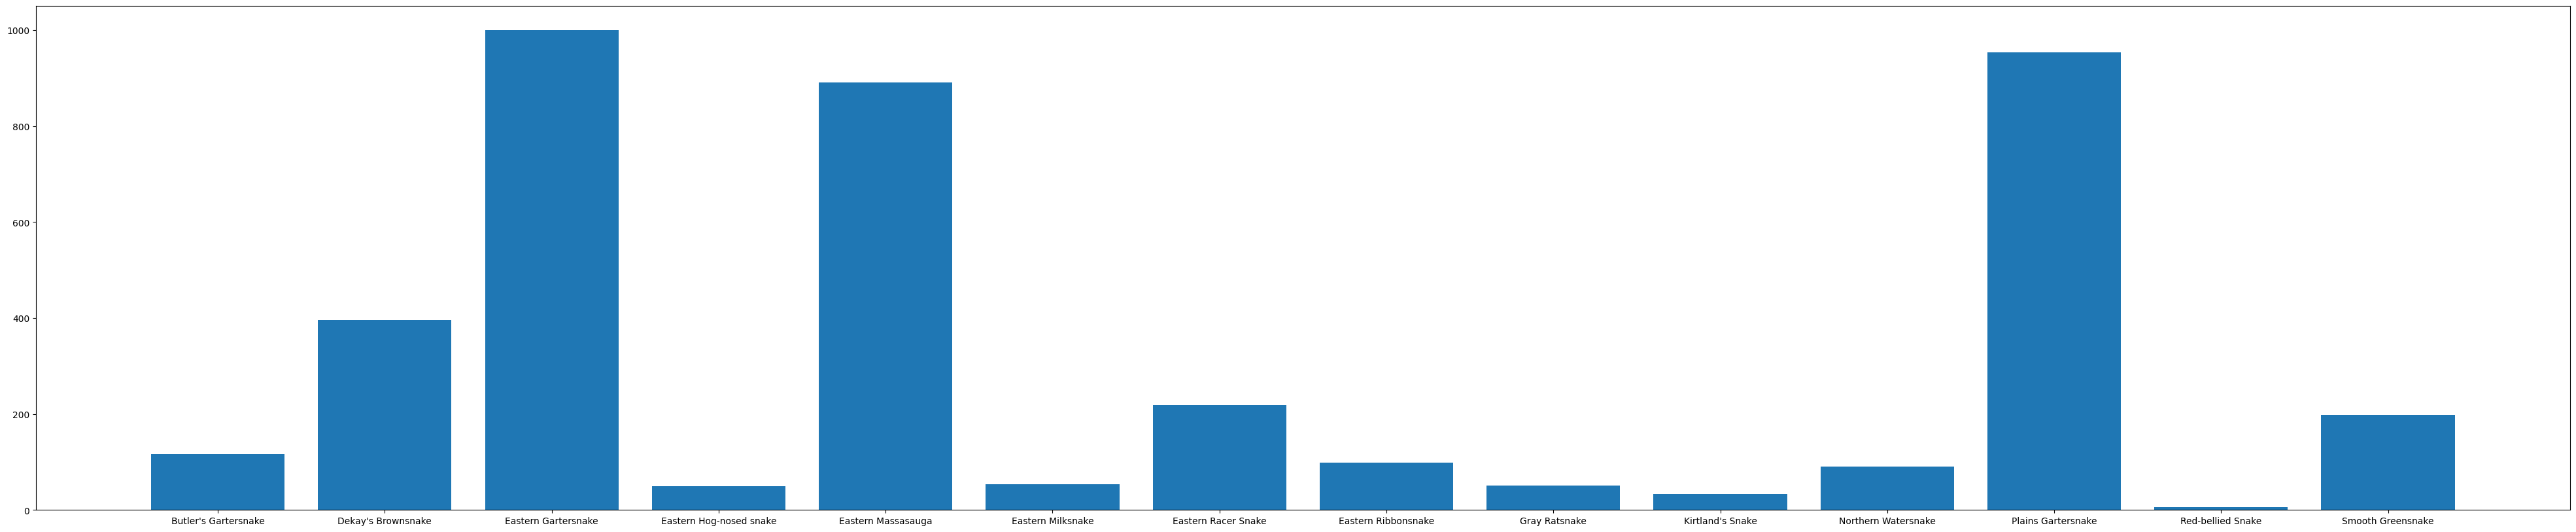

["Butler's Gartersnake", "Dekay's Brownsnake", 'Eastern Gartersnake', 'Eastern Hog-nosed snake', 'Eastern Massasauga', 'Eastern Milksnake', 'Eastern Racer Snake', 'Eastern Ribbonsnake', 'Gray Ratsnake', "Kirtland's Snake", 'Northern Watersnake', 'Plains Gartersnake', 'Red-bellied Snake', 'Smooth Greensnake'] [116, 396, 1000, 50, 891, 54, 219, 99, 51, 33, 90, 954, 6, 198]


In [53]:
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())

num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
#print(unique, counts)
class_num = len(classes)
for i in range(class_num):
    if i not in valdict:
        valdict[i] = 0
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()
print(xlabel, num_values)

In [54]:

# Assuming you have the class labels and indices
classes = list(train_generator.class_indices.keys())

# Get class counts for the train set
cls_train = train_generator.classes
unique_train, counts_train = np.unique(cls_train, return_counts=True)
train_dict = OrderedDict(zip(unique_train, counts_train))

# Get class counts for the test set
cls_test = testing_generator.classes
unique_test, counts_test = np.unique(cls_test, return_counts=True)
test_dict = OrderedDict(zip(unique_test, counts_test))

# Get class counts for the validation set
cls_val = test_generator.classes
unique_val, counts_val = np.unique(cls_val, return_counts=True)
val_dict = OrderedDict(zip(unique_val, counts_val))

for i in range(len(classes)):
    label = classes[i]
    if i not in train_dict:
        train_dict[i] = 0
    if i not in test_dict:
        test_dict[i] = 0
    if i not in val_dict:
        val_dict[i] = 0
        
# Create a table with the counts for each class
table_data = {'Class': classes, 'Train': [], 'Test': [], 'Validation': []}

for label in classes:
    table_data['Train'].append(train_dict[train_generator.class_indices[label]])
    table_data['Test'].append(test_dict[test_generator.class_indices[label]])
    table_data['Validation'].append(val_dict[testing_generator.class_indices[label]])

# Display the table
import pandas as pd
df = pd.DataFrame(table_data)
print(df)


                      Class  Train  Test  Validation
0      Butler's Gartersnake    116    24          15
1        Dekay's Brownsnake    396    81          52
2       Eastern Gartersnake   1000   150         100
3   Eastern Hog-nosed snake     50    11           6
4        Eastern Massasauga    891   180         118
5         Eastern Milksnake     54    11           7
6       Eastern Racer Snake    219    45          29
7       Eastern Ribbonsnake     99    21          13
8             Gray Ratsnake     51    11           6
9          Kirtland's Snake     33     7           4
10      Northern Watersnake     90    19          12
11       Plains Gartersnake    954   191         127
12        Red-bellied Snake      6     2           1
13        Smooth Greensnake    198    40          26


## Download MobileNetV2 model

In [55]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

 block_2_add (Add)              (None, None, None,   0           ['block_1_project_BN[0][0]',     
                                24)                               'block_2_project_BN[0][0]']     
                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
          

                                                                                                  
 block_6_expand (Conv2D)        (None, None, None,   6144        ['block_5_add[0][0]']            
                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_p

                                384)                                                              
                                                                                                  
 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
          

 block_12_expand_relu (ReLU)    (None, None, None,   0           ['block_12_expand_BN[0][0]']     
                                576)                                                              
                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
          

                                                                                                  
 block_15_depthwise (DepthwiseC  (None, None, None,   8640       ['block_15_expand_relu[0][0]']   
 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_

"Frozen" all weights pretrained models

In [56]:
pretrained_model.trainable = False

# Created main layers for end MobileNetV2 model

In [57]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(class_num, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [58]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                         

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

# Train a composite neural network based on MobileNetV2 model

In [59]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

filepath="inceptionv3_snakes.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch = 32
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=35,
    verbose=1)

Epoch 1/35
32/32 [==============================] - ETA: 0s - loss: 1.8481 - accuracy: 0.4482
Epoch 1: val_loss improved from inf to 1.42536, saving model to inceptionv3_snakes.h5
32/32 [==============================] - 125s 4s/step - loss: 1.8481 - accuracy: 0.4482 - val_loss: 1.4254 - val_accuracy: 0.5750 - lr: 0.0010
Epoch 2/35
32/32 [==============================] - ETA: 0s - loss: 1.2027 - accuracy: 0.5864
Epoch 2: val_loss improved from 1.42536 to 1.06124, saving model to inceptionv3_snakes.h5
32/32 [==============================] - 101s 3s/step - loss: 1.2027 - accuracy: 0.5864 - val_loss: 1.0612 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/35
32/32 [==============================] - ETA: 0s - loss: 1.0072 - accuracy: 0.6553
Epoch 3: val_loss improved from 1.06124 to 0.80021, saving model to inceptionv3_snakes.h5
32/32 [==============================] - 97s 3s/step - loss: 1.0072 - accuracy: 0.6553 - val_loss: 0.8002 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 4/35
32/32 [======

Epoch 28/35
32/32 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8538
Epoch 28: val_loss did not improve from 0.34423
32/32 [==============================] - 96s 3s/step - loss: 0.4069 - accuracy: 0.8538 - val_loss: 0.4553 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 29/35
32/32 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8521
Epoch 29: val_loss did not improve from 0.34423
32/32 [==============================] - 96s 3s/step - loss: 0.4073 - accuracy: 0.8521 - val_loss: 0.4013 - val_accuracy: 0.8500 - lr: 0.0010
Epoch 30/35
32/32 [==============================] - ETA: 0s - loss: 0.4096 - accuracy: 0.8445
Epoch 30: val_loss did not improve from 0.34423
32/32 [==============================] - 96s 3s/step - loss: 0.4096 - accuracy: 0.8445 - val_loss: 0.3522 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 31/35
32/32 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.8606
Epoch 31: val_loss did not improve from 0.34423
32

In [60]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 86.51%
[INFO] Loss:  0.37743595242500305


Text(0.5, 1.0, 'Accuracy Curves')

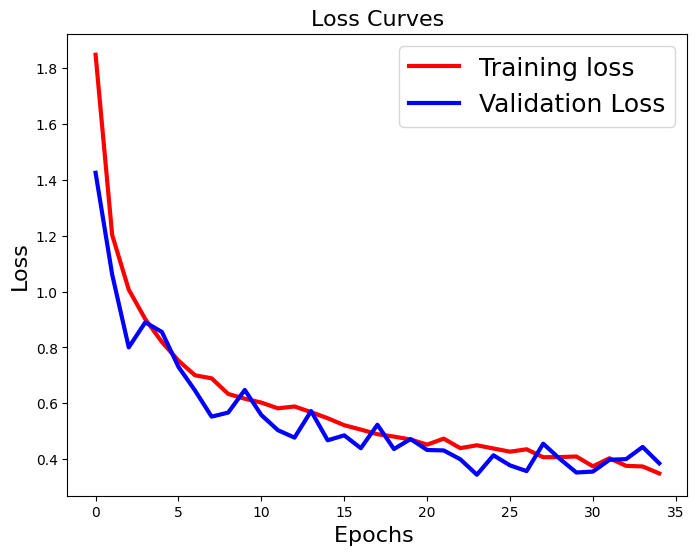

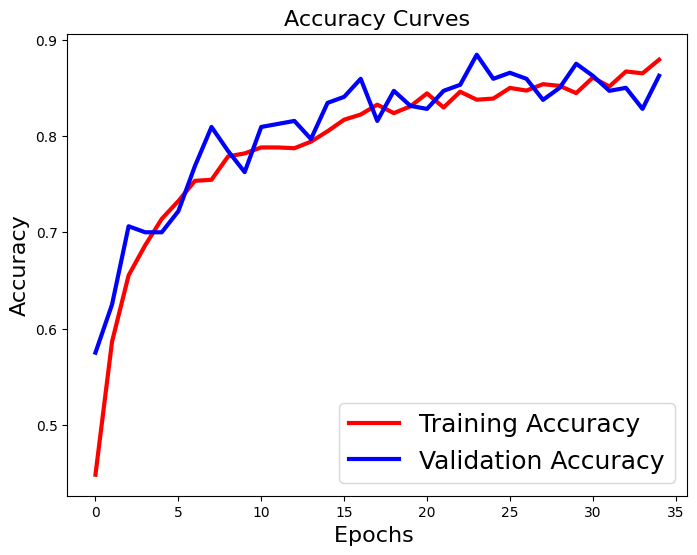

In [61]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

In [62]:
Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testing_generator.classes, y_pred)
class_counts = np.bincount(testing_generator.classes)
sorted_indices = np.argsort(class_counts)[::-1]
sorted_classes = [classes[i] for i in sorted_indices]
sorted_cm = cm[:, sorted_indices][sorted_indices, :]
group_counts = ["{0:0.0f}".format(value) for value in sorted_cm.flatten()]
group_percentage = (sorted_cm.T / sorted_cm.sum(axis=1)).T
group_percentages = ["{0:.1%}".format(value) for value in group_percentage.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(class_num, class_num)

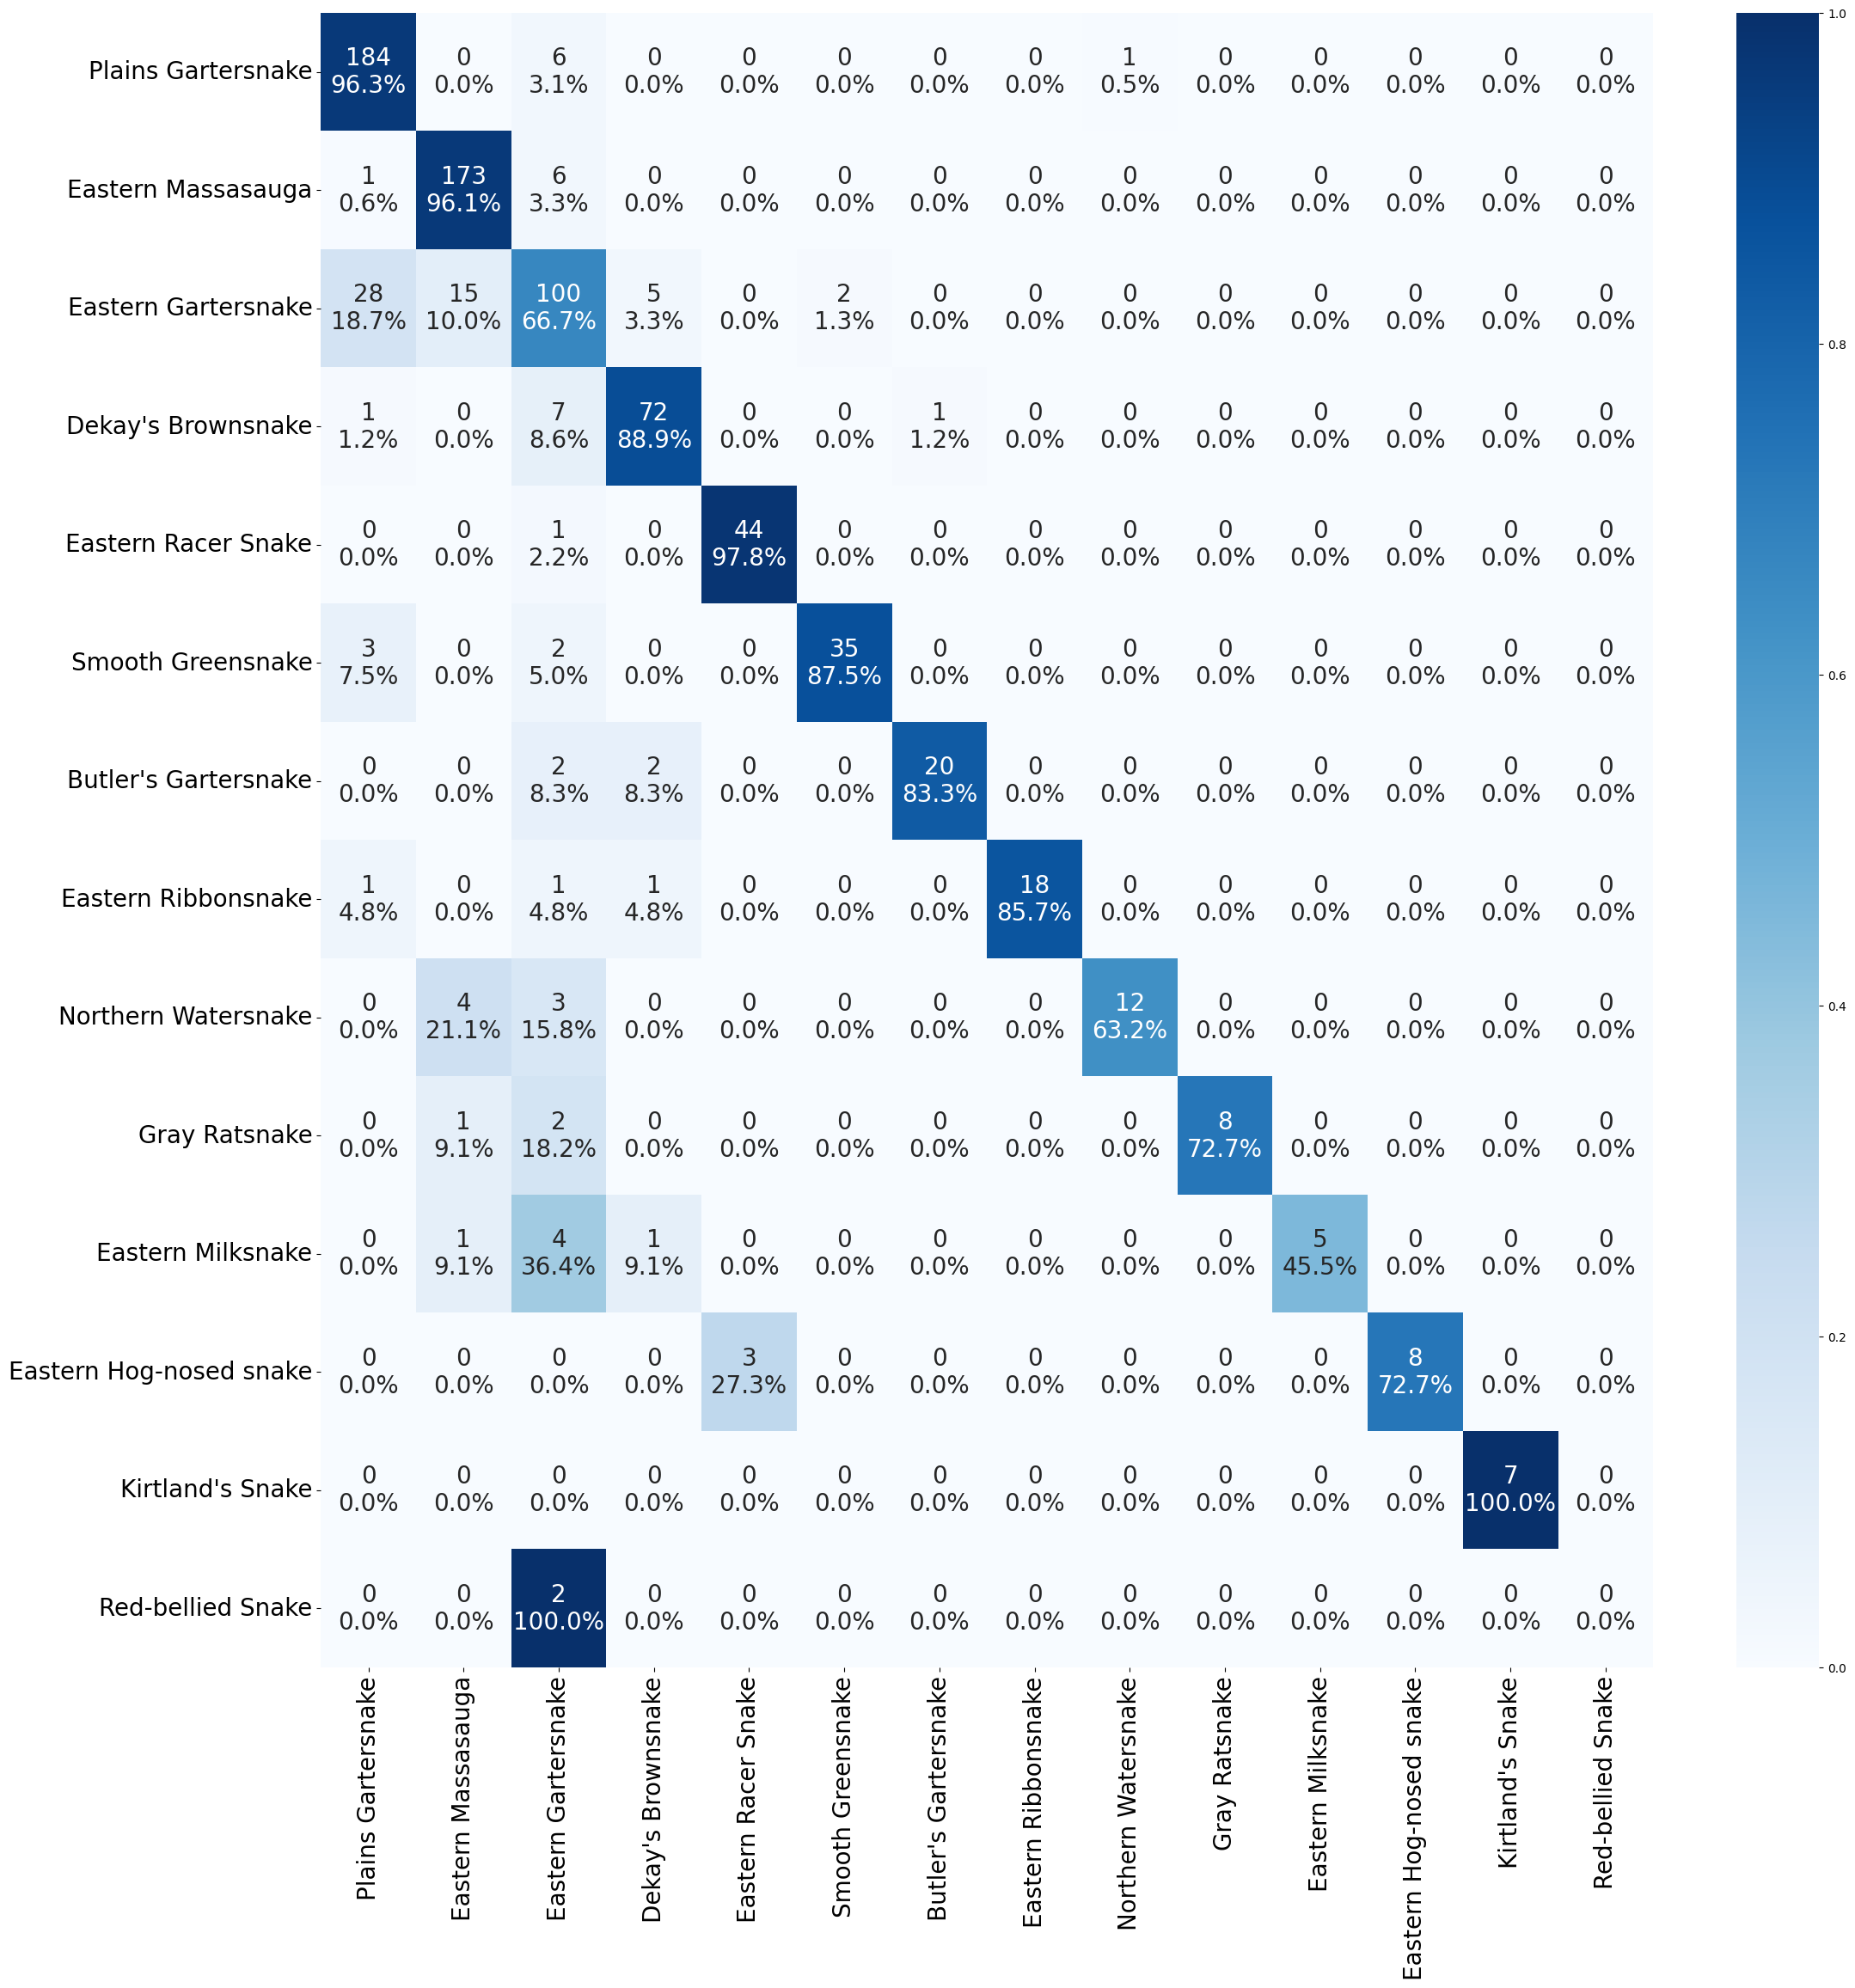

In [69]:
plt.figure(figsize=(25, 25))
heatmap = sns.heatmap(group_percentage, annot=labels, fmt='', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes,annot_kws={"size": 20})
heatmap.set_yticklabels(heatmap.get_yticklabels(),size = 20, rotation=0)
heatmap.set_xticklabels(heatmap.get_xticklabels(),size = 20, rotation=90)
plt.show()

In [64]:
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=classes))

Classification Report
                         precision    recall  f1-score   support

   Butler's Gartersnake       0.95      0.83      0.89        24
     Dekay's Brownsnake       0.89      0.89      0.89        81
    Eastern Gartersnake       0.74      0.67      0.70       150
Eastern Hog-nosed snake       1.00      0.73      0.84        11
     Eastern Massasauga       0.89      0.96      0.93       180
      Eastern Milksnake       1.00      0.45      0.62        11
    Eastern Racer Snake       0.94      0.98      0.96        45
    Eastern Ribbonsnake       1.00      0.86      0.92        21
          Gray Ratsnake       1.00      0.73      0.84        11
       Kirtland's Snake       1.00      1.00      1.00         7
    Northern Watersnake       0.92      0.63      0.75        19
     Plains Gartersnake       0.84      0.96      0.90       191
      Red-bellied Snake       0.00      0.00      0.00         2
      Smooth Greensnake       0.95      0.88      0.91        40

 

# Distribution of human review vs error

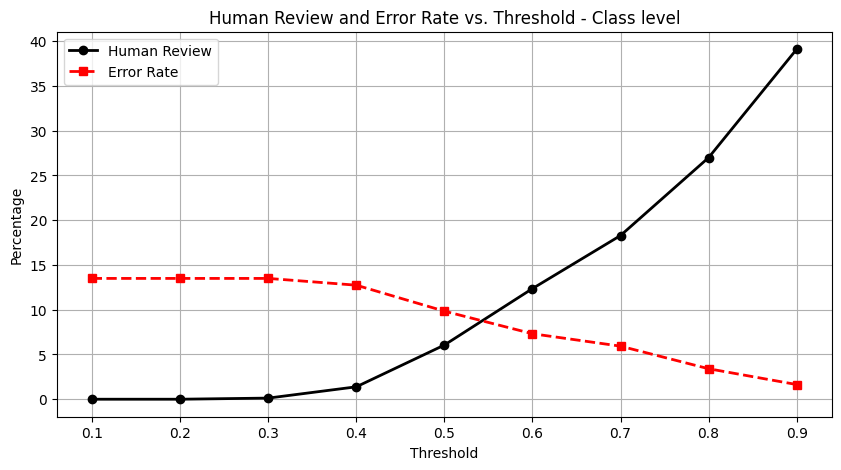

In [65]:
y_true = testing_generator.classes
cm = confusion_matrix(testing_generator.classes, y_pred)
class_counts = np.bincount(y_true)
sorted_indices = np.argsort(class_counts)[::-1]
sorted_classes = [classes[i] for i in sorted_indices]
sorted_cm = cm[:, sorted_indices][sorted_indices, :]

group_counts = ["{0:0.0f}".format(value) for value in sorted_cm.flatten()]
group_percentage = (sorted_cm.T / sorted_cm.sum(axis=1)).T

buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]

correct_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}
incorrect_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = np.argmax(Y_pred[i])
    max_probability = Y_pred[i][predicted_label]
    
    for bucket in buckets:
        if bucket[0] <= max_probability < bucket[1]:
            if true_label == predicted_label:
                correct_bucket_counts[f'{bucket[0]}'] += 1
            else:
                incorrect_bucket_counts[f'{bucket[0]}'] += 1
            break

total_correct = sum(correct_bucket_counts.values())
total_incorrect = sum(incorrect_bucket_counts.values())
total_images = total_correct + total_incorrect

correct_bucket_probabilities = {key: value / total_correct for key, value in correct_bucket_counts.items()}
incorrect_bucket_probabilities = {key: value / total_incorrect for key, value in incorrect_bucket_counts.items()}

thresholds = np.arange(0.9, 0.0, -0.1).round(1)   # Starting from 0.9 and going down to 0.1 in increments of 0.1
human_bucket_probabilities = []
error = []

for threshold_value in thresholds:
    sum_counts_below_threshold = sum(correct_bucket_counts[key] + incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) < threshold_value)
    human_bucket_probability = (sum_counts_below_threshold / total_images) * 100
    human_bucket_probabilities.append(human_bucket_probability)
    error_rate = (sum(incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) >= threshold_value))/total_images
    error.append(error_rate*100)

plt.figure(figsize=(10, 5))

plt.plot(thresholds, human_bucket_probabilities, marker='o', linestyle='-', linewidth=2, color='black', label='Human Review')
plt.plot(thresholds, error, marker='s', linestyle='--',linewidth=2, color='red', label='Error Rate')

plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Human Review and Error Rate vs. Threshold - Class level')
plt.legend()
plt.grid(True)
plt.show()


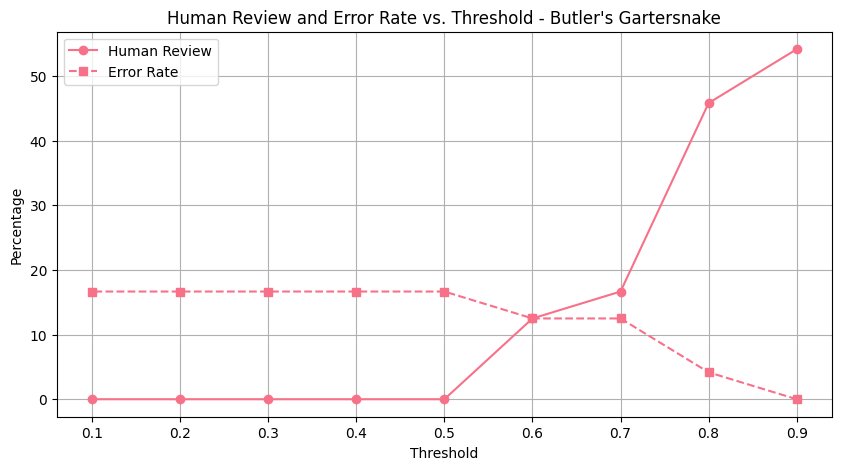

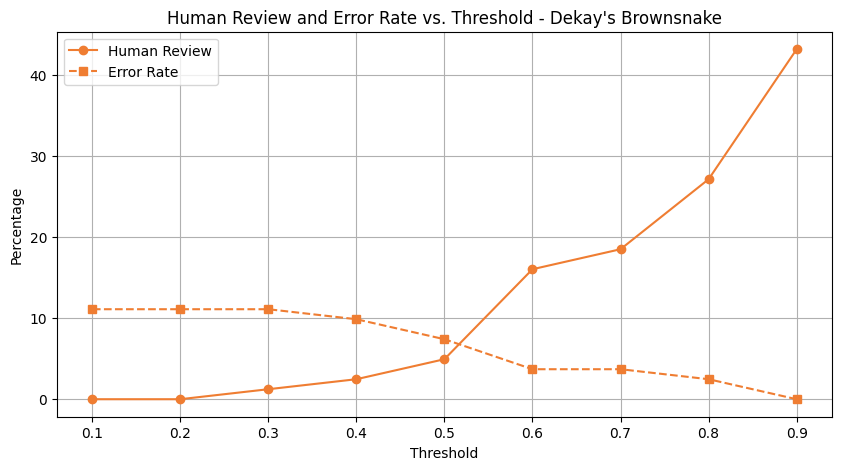

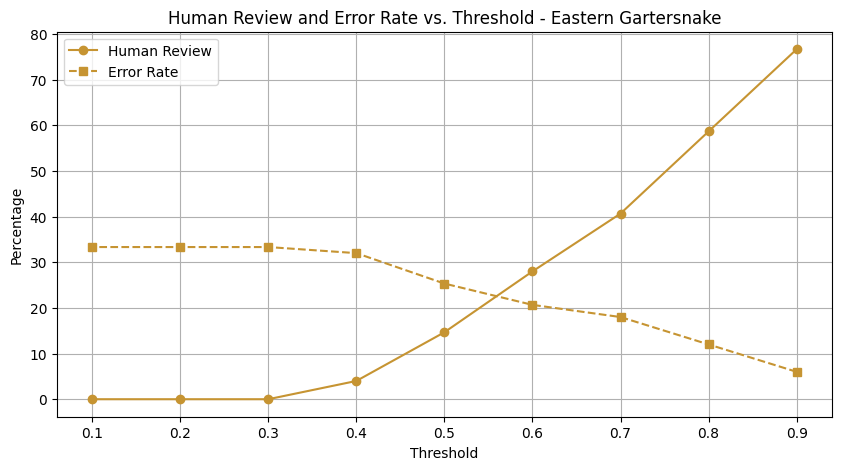

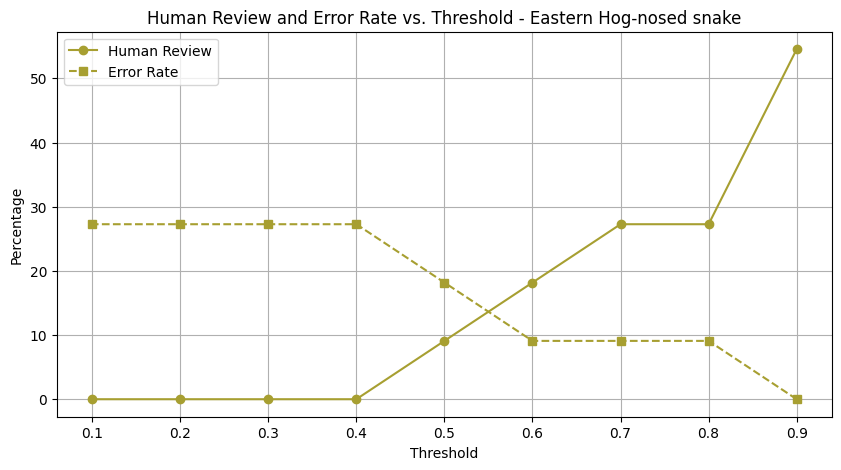

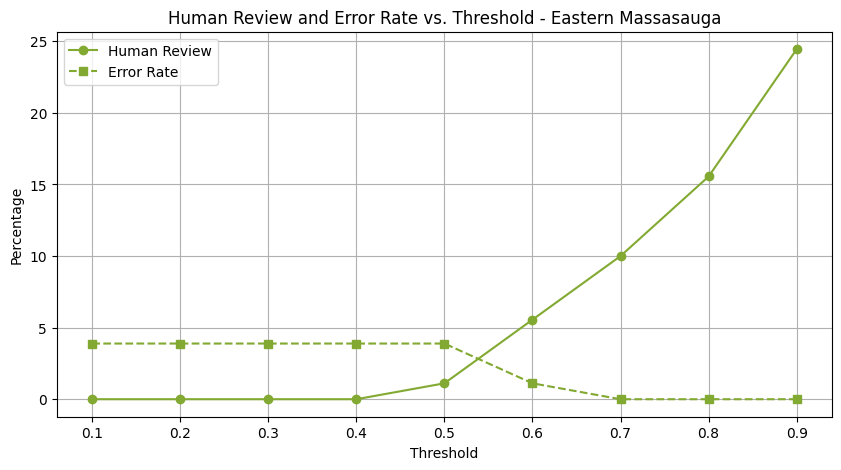

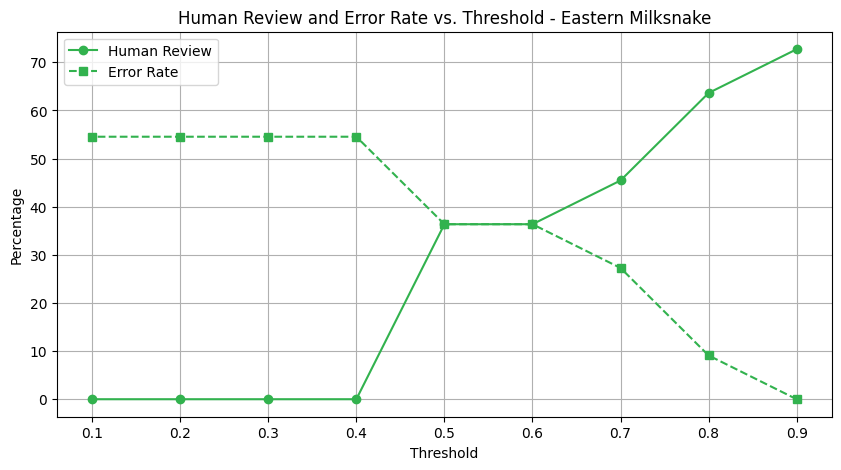

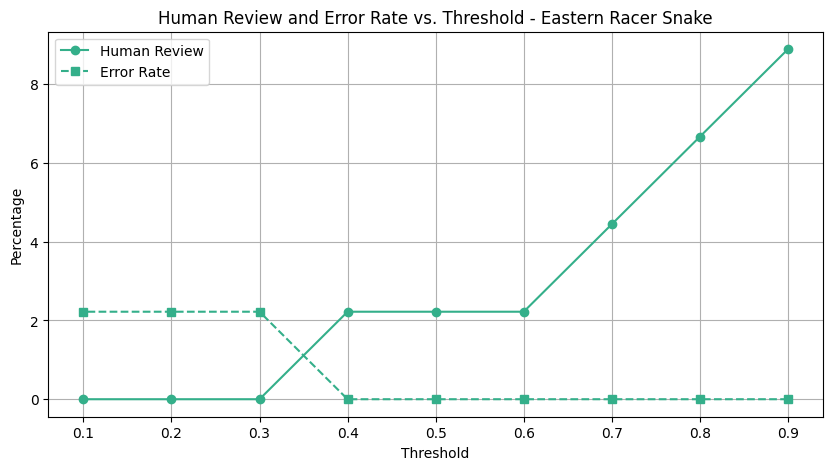

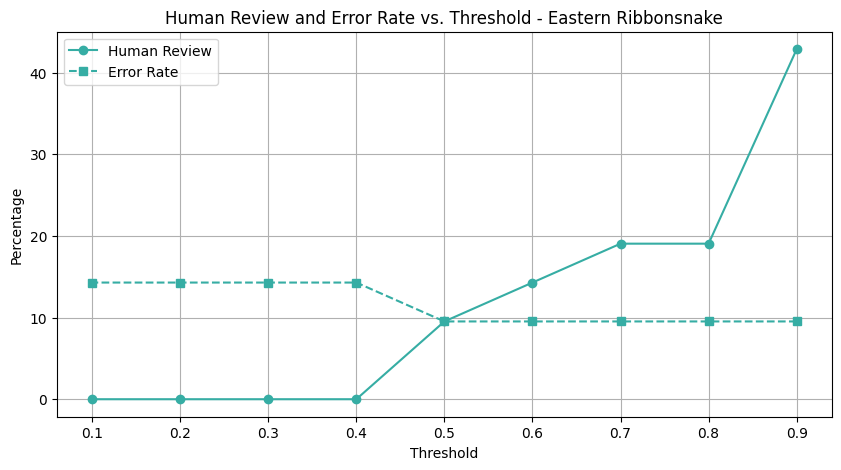

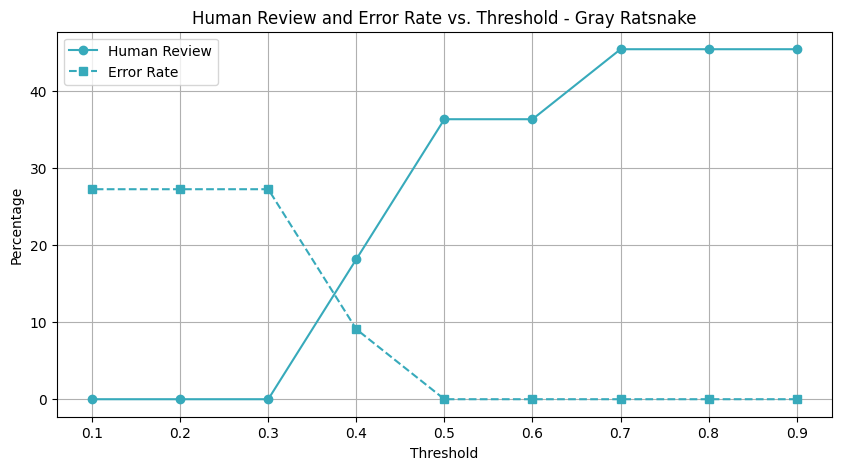

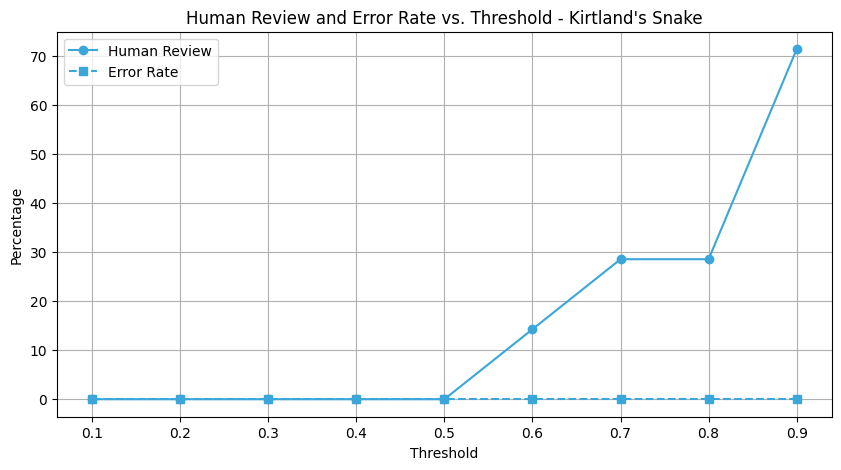

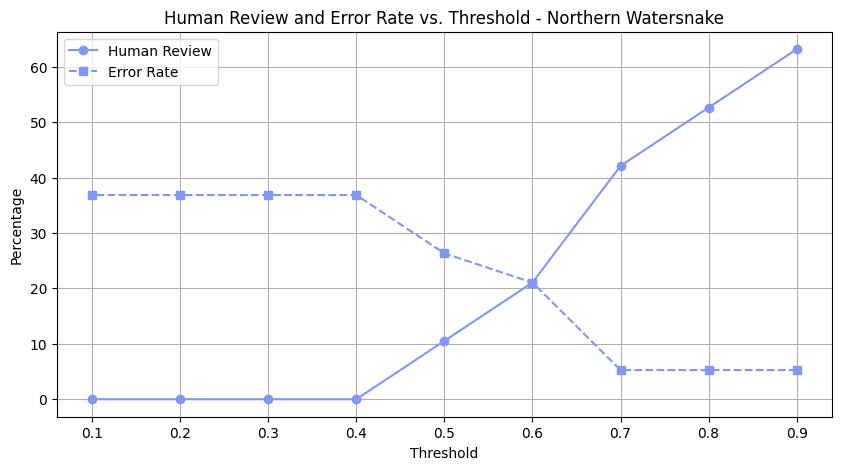

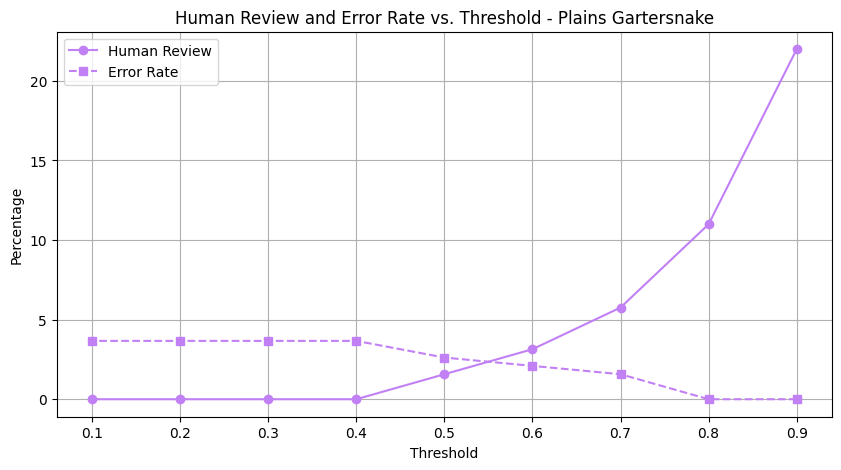

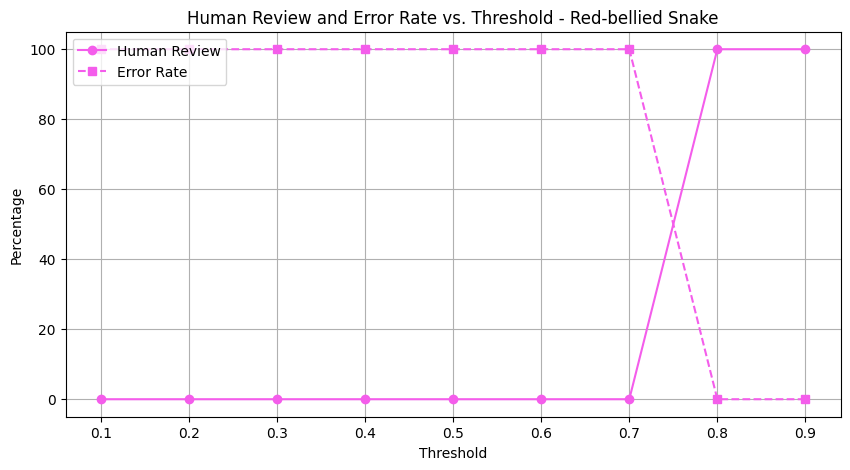

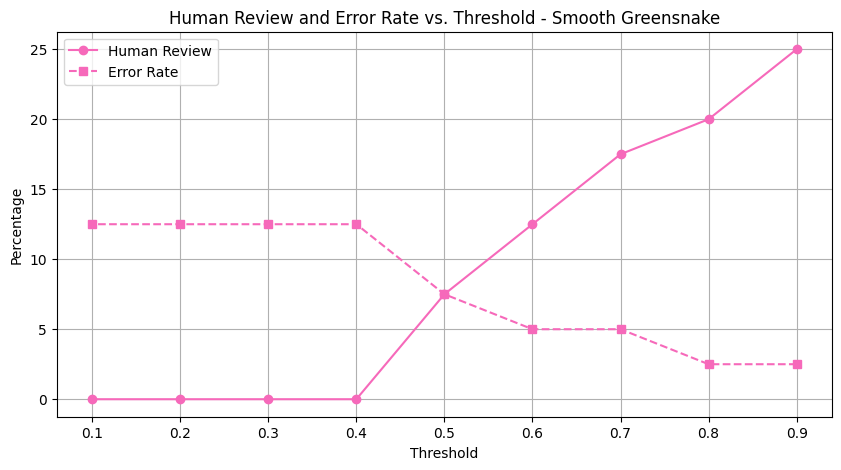

In [66]:
buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]
class_colors = sns.color_palette("husl", n_colors=len(sorted_classes))
combined_human_probabilities = []
combined_error_rates = []
for i, label_class in enumerate(range(len(sorted_classes))):
    correct_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}
    incorrect_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}

    for j in range(len(y_true)):
        true_label = y_true[j]
        predicted_label = np.argmax(Y_pred[j])
        max_probability = Y_pred[j][predicted_label]
        if true_label == label_class:
            for bucket in buckets:
                if bucket[0] <= max_probability < bucket[1]:
                    if true_label == predicted_label:
                        correct_bucket_counts[f'{bucket[0]}'] += 1
                    else:
                        incorrect_bucket_counts[f'{bucket[0]}'] += 1
                    break

    total_correct = sum(correct_bucket_counts.values())
    total_incorrect = sum(incorrect_bucket_counts.values())
    total_images = total_correct + total_incorrect
    correct_bucket_probabilities = {key: value / total_correct if total_correct != 0 else 0 for key, value in correct_bucket_counts.items()}
    incorrect_bucket_probabilities = {key: value / total_incorrect if total_incorrect != 0 else 0 for key, value in incorrect_bucket_counts.items()}
    thresholds = np.arange(0.9, 0.0, -0.1).round(1)   # Starting from 0.9 and going down to 0.1 in increments of 0.1
    human_bucket_probabilities = []
    error = []

    for threshold_value in thresholds:
        sum_counts_below_threshold = sum(correct_bucket_counts[key] + incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) < threshold_value)
        human_bucket_probability = (sum_counts_below_threshold / total_images) * 100
        human_bucket_probabilities.append(human_bucket_probability)
        error_rate = (sum(incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) >= threshold_value))/total_images
        error.append(error_rate*100)

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, human_bucket_probabilities, marker='o', linestyle='-', color=class_colors[i], label='Human Review')
    plt.plot(thresholds, error, marker='s', linestyle='--', color=class_colors[i], label='Error Rate')
    plt.xlabel('Threshold')
    plt.ylabel(f'Percentage')
    plt.tick_params(axis='y')
    plt.legend(loc='upper left')
    plt.title(f'Human Review and Error Rate vs. Threshold - {classes[label_class]}')
    plt.grid(True)
    plt.show()

    

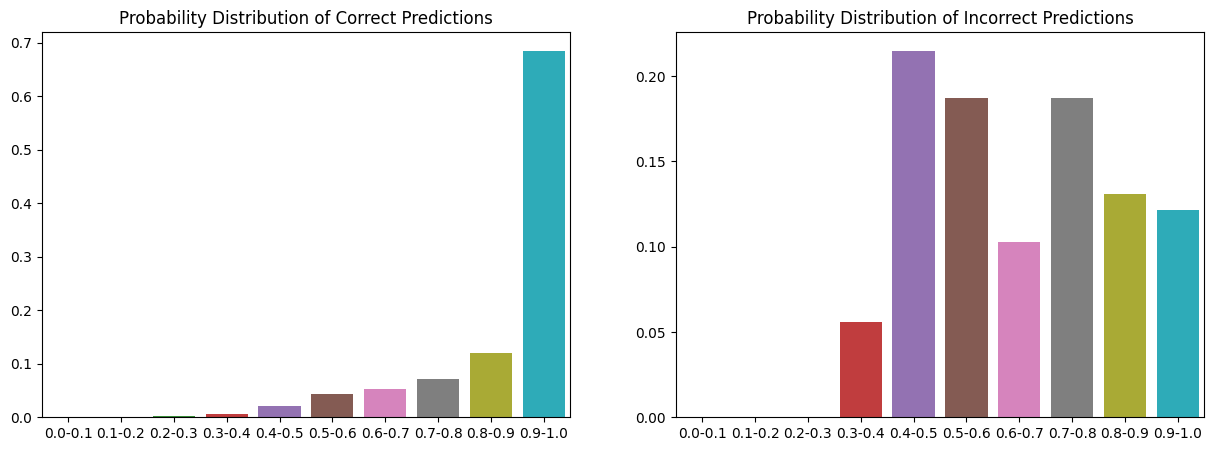

In [67]:
buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]

# Classify probabilities into buckets for both correct and incorrect predictions
correct_bucket_counts = {f'{bucket[0]}-{bucket[1]}': 0 for bucket in buckets}
incorrect_bucket_counts = {f'{bucket[0]}-{bucket[1]}': 0 for bucket in buckets}

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = np.argmax(Y_pred[i])
    max_probability = Y_pred[i][predicted_label]
    
    # Determine the probability bucket for the prediction
    for bucket in buckets:
        if bucket[0] <= max_probability < bucket[1]:
            if true_label == predicted_label:
                correct_bucket_counts[f'{bucket[0]}-{bucket[1]}'] += 1
            else:
                incorrect_bucket_counts[f'{bucket[0]}-{bucket[1]}'] += 1
            break

# Calculate the probability distribution of correct and incorrect predictions
total_correct = sum(correct_bucket_counts.values())
total_incorrect = sum(incorrect_bucket_counts.values())

correct_bucket_probabilities = {key: value / total_correct for key, value in correct_bucket_counts.items()}
incorrect_bucket_probabilities = {key: value / total_incorrect for key, value in incorrect_bucket_counts.items()}

# Visualize the results

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(correct_bucket_probabilities.keys()), y=list(correct_bucket_probabilities.values()))
plt.title('Probability Distribution of Correct Predictions')

plt.subplot(1, 2, 2)
sns.barplot(x=list(incorrect_bucket_probabilities.keys()), y=list(incorrect_bucket_probabilities.values()))
plt.title('Probability Distribution of Incorrect Predictions')

plt.show()
